# Importing Libraries

In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.6.0


# Preparing Training and Test Sets

In [2]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [3]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
        self.image_dirs = image_dirs
        self.transform = transform
        
        
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        
        return self.transform(image), self.class_names.index(class_name)

# Decide GPU or CPU

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Using GPU')
else:
    device = torch.device('cpu')
    print('Using CPU')

Using GPU


# Image Transformations

In [5]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [6]:
train_dirs = {
    'normal': 'COVID-19 Radiography Database/normal',
    'viral': 'COVID-19 Radiography Database/viral',
    'covid': 'COVID-19 Radiography Database/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1311 normal examples
Found 1315 viral examples
Found 189 covid examples


In [7]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [8]:
batch_size = 5
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

print('Num of training batches', len(dl_train))
print('Num of test batches', len(dl_test))

Num of training batches 563
Num of test batches 18


# Data Visualization

In [9]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize = (8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks = [], yticks = [])
        image = image.cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green' if preds[i] == labels[i] else 'red'

        plt.xlabel(f'{class_names[int(labels[i].cpu().numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].cpu().numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

# Creating the Model

In [10]:
vgg16 = torchvision.models.vgg16(pretrained=True)

In [11]:
vgg16.classifier._modules['6'] = torch.nn.Linear(4096, 3)
vgg16 = vgg16.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.parameters(), lr = 3e-5)

In [12]:
def show_preds():
    vgg16.eval()
    images, labels = next(iter(dl_test))
    images, labels = images.to(device), labels.to(device)
    outputs = vgg16(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

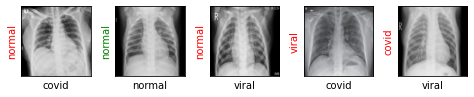

In [13]:
show_preds()

In [14]:
accs = []
losses = []

# Training the Model

In [15]:
def train(epochs):
    print('starting training..')
    for e in range(epochs):
        print('='*20)
        print(f'starting epoch {e + 1}/{epochs}')
        print('=' * 20)
        train_loss = 0
        #resnet18.train()
        vgg16.train()
        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            #outputs = resnet18(images)
            outputs = vgg16(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('evaluating at step', train_step)
                acc = 0.
                val_loss = 0.
                #resnet18.eval()
                vgg16.eval()
                
                for val_step, (images, labels) in enumerate(dl_test):
                    images, labels = images.to(device), labels.to(device)
                    #outputs = resnet18(images)
                    outputs = vgg16(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    _, preds = torch.max(outputs, 1)
                    acc += sum((preds == labels).cpu().numpy())
                val_loss /= (val_step + 1)
                acc /= len(test_dataset)
                accs.append(acc)
                losses.append(val_loss)
                print(f'Val loss: {val_loss:.4f}, Acc: {acc:.4f}')
                show_preds()
                #resnet18.train()
                vgg16.train()
        train_loss /= (train_step + 1)
        print(f'Training loss: {train_loss:.4f}')
        

starting training..
starting epoch 1/1
evaluating at step 0
Val loss: 1.0724, Acc: 0.4333


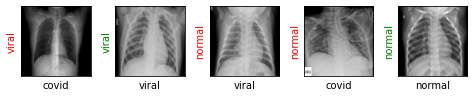

RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 4.00 GiB total capacity; 2.69 GiB already allocated; 73.35 MiB free; 2.75 GiB reserved in total by PyTorch)
Exception raised from malloc at ..\c10\cuda\CUDACachingAllocator.cpp:272 (most recent call first):
00007FFD9E8575A200007FFD9E857540 c10.dll!c10::Error::Error [<unknown file> @ <unknown line number>]
00007FFD9E7F9C0600007FFD9E7F9B90 c10_cuda.dll!c10::CUDAOutOfMemoryError::CUDAOutOfMemoryError [<unknown file> @ <unknown line number>]
00007FFD9E80069600007FFD9E7FF370 c10_cuda.dll!c10::cuda::CUDACachingAllocator::init [<unknown file> @ <unknown line number>]
00007FFD9E80083A00007FFD9E7FF370 c10_cuda.dll!c10::cuda::CUDACachingAllocator::init [<unknown file> @ <unknown line number>]
00007FFD9E7F509900007FFD9E7F4EB0 c10_cuda.dll!c10::cuda::CUDAStream::unpack [<unknown file> @ <unknown line number>]
00007FFD33C91FF100007FFD33C91EB0 torch_cuda.dll!at::native::empty_cuda [<unknown file> @ <unknown line number>]
00007FFD33DA8AFE00007FFD33D4E0A0 torch_cuda.dll!at::native::set_storage_cuda_ [<unknown file> @ <unknown line number>]
00007FFD33DA42A500007FFD33D4E0A0 torch_cuda.dll!at::native::set_storage_cuda_ [<unknown file> @ <unknown line number>]
00007FFD5B4E1A3A00007FFD5B4CD9D0 torch_cpu.dll!at::native::mkldnn_sigmoid_ [<unknown file> @ <unknown line number>]
00007FFD5B4E000500007FFD5B4CD9D0 torch_cpu.dll!at::native::mkldnn_sigmoid_ [<unknown file> @ <unknown line number>]
00007FFD5B5B18A000007FFD5B5A8FA0 torch_cpu.dll!at::bucketize_out [<unknown file> @ <unknown line number>]
00007FFD5B5C28DC00007FFD5B5C2850 torch_cpu.dll!at::empty [<unknown file> @ <unknown line number>]
00007FFD3324F5E400007FFD3324F560 torch_cuda.dll!at::native::mm_cuda [<unknown file> @ <unknown line number>]
00007FFD33DB1B0F00007FFD33D4E0A0 torch_cuda.dll!at::native::set_storage_cuda_ [<unknown file> @ <unknown line number>]
00007FFD33DA1B2200007FFD33D4E0A0 torch_cuda.dll!at::native::set_storage_cuda_ [<unknown file> @ <unknown line number>]
00007FFD5B5AD94900007FFD5B5A8FA0 torch_cpu.dll!at::bucketize_out [<unknown file> @ <unknown line number>]
00007FFD5B5E057700007FFD5B5E0520 torch_cpu.dll!at::mm [<unknown file> @ <unknown line number>]
00007FFD5C93EC7900007FFD5C84E010 torch_cpu.dll!torch::autograd::GraphRoot::apply [<unknown file> @ <unknown line number>]
00007FFD5B0F715700007FFD5B0F6290 torch_cpu.dll!at::indexing::TensorIndex::boolean [<unknown file> @ <unknown line number>]
00007FFD5B5AD94900007FFD5B5A8FA0 torch_cpu.dll!at::bucketize_out [<unknown file> @ <unknown line number>]
00007FFD5B6C210700007FFD5B6C20B0 torch_cpu.dll!at::Tensor::mm [<unknown file> @ <unknown line number>]
00007FFD5C7DB96900007FFD5C7DA760 torch_cpu.dll!torch::autograd::profiler::Event::kind [<unknown file> @ <unknown line number>]
00007FFD5C7917EC00007FFD5C791580 torch_cpu.dll!torch::autograd::generated::AddmmBackward::apply [<unknown file> @ <unknown line number>]
00007FFD5C787E9100007FFD5C787B50 torch_cpu.dll!torch::autograd::Node::operator() [<unknown file> @ <unknown line number>]
00007FFD5CCEF9BA00007FFD5CCEF300 torch_cpu.dll!torch::autograd::Engine::add_thread_pool_task [<unknown file> @ <unknown line number>]
00007FFD5CCF03AD00007FFD5CCEFFD0 torch_cpu.dll!torch::autograd::Engine::evaluate_function [<unknown file> @ <unknown line number>]
00007FFD5CCF4FE200007FFD5CCF4CA0 torch_cpu.dll!torch::autograd::Engine::thread_main [<unknown file> @ <unknown line number>]
00007FFD5CCF4C4100007FFD5CCF4BC0 torch_cpu.dll!torch::autograd::Engine::thread_init [<unknown file> @ <unknown line number>]
00007FFD774708F700007FFD77449F80 torch_python.dll!THPShortStorage_New [<unknown file> @ <unknown line number>]
00007FFD5CCEBF1400007FFD5CCEB780 torch_cpu.dll!torch::autograd::Engine::get_base_engine [<unknown file> @ <unknown line number>]
00007FFDDC4310B200007FFDDC430F70 ucrtbase.dll!beginthreadex [<unknown file> @ <unknown line number>]
00007FFDDCE57C2400007FFDDCE57C10 KERNEL32.DLL!BaseThreadInitThunk [<unknown file> @ <unknown line number>]
00007FFDDE52D4D100007FFDDE52D4B0 ntdll.dll!RtlUserThreadStart [<unknown file> @ <unknown line number>]


In [16]:
train(epochs = 1)

# Some visualizations

In [ ]:
show_preds()

In [ ]:
steps = list(range(1, 30))
plt.plot(steps, accs, label = 'acc')
plt.plot(steps, losses, label = 'loss')
plt.legend()
plt.show()